In [3]:
import numpy as np
import networkx as nx
import random
import cvxpy as cp
import matplotlib.pyplot as plt
from pyomo.environ import *
from torch_geometric.utils.convert import from_networkx
from collections import deque
from copy import deepcopy
from jax import grad, jit
from jax.scipy.optimize import minimize
import jax.numpy as jnp

/home/mohammeddhiyaeddinegouaouri/.conda/envs/phd/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/mohammeddhiyaeddinegouaouri/.conda/envs/phd/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/mohammeddhiyaeddinegouaouri/.conda/envs/phd/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/mohammeddhiyaeddinegouaouri/.conda/envs/phd/lib/python3.10/site-packages/torch_cluster/_version_cpu.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/home/mohammeddhiyaeddinegouaouri/.conda/envs/phd/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An is

In [4]:
num_microservices = 10
num_edge_servers = 10

BLOCK_SIZE = 1 # For 1GB

microservice_graph = nx.DiGraph()
edge_network = nx.erdos_renyi_graph(num_edge_servers, 0.5, seed=123, directed=False)

for m in range(num_microservices):
    microservice_graph.add_node(m, 
                                requested_cpu=random.randint(100, 500), 
                                requested_memory=random.randint(512, 1024), 
                                requested_disk=random.randint(BLOCK_SIZE, 4*BLOCK_SIZE)
            )

# Add edges ensuring no cycles (DAG)
possible_edges = [(i, j) for i in range(num_microservices) for j in range(i + 1, num_microservices)]
for _ in range(num_microservices * 2):  # Add twice the number of nodes as edges
    if not possible_edges:
        break
    m1, m2 = random.choice(possible_edges)
    possible_edges.remove((m1, m2))
    bandwidth = random.randint(1, 10)
    microservice_graph.add_edge(m1, m2, bw_min=bandwidth)


for n in range(num_edge_servers):
    # Update node attr
    edge_network.add_node(n, 
                          available_cpu=random.randint(4000, 8000), 
                          available_memory=random.randint(4096, 2 * 4096), 
                          available_disk=random.randint(4*BLOCK_SIZE, 16*BLOCK_SIZE),
                          energy_per_cpu_unit=random.random()
                        )

for n1, n2 in edge_network.edges():
    # n1, n2 = random.sample(range(num_edge_servers), 2)
    # Update edge attr
    bandwidth = random.randint(10, 100)
    edge_network.add_edge(n1, n2, bw=bandwidth, reverse_bw=1/bandwidth)

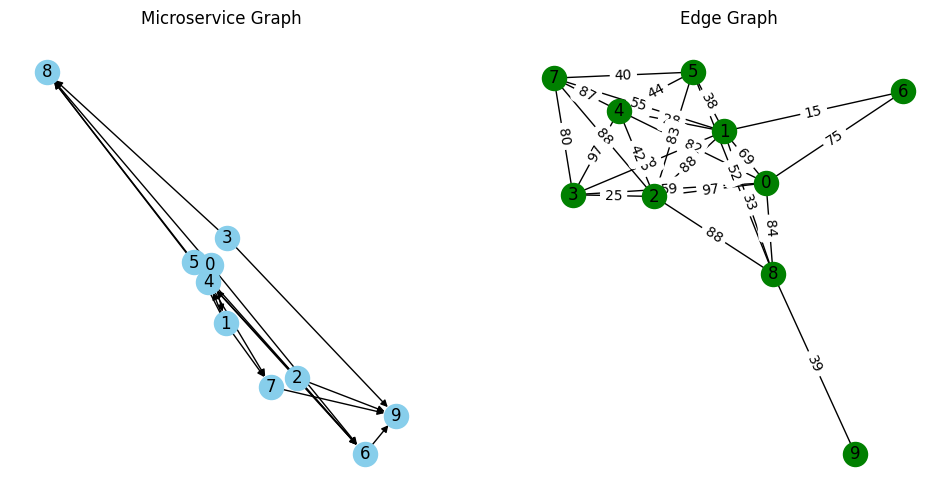

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(microservice_graph, with_labels=True, node_color='skyblue')
plt.title("Microservice Graph")

plt.subplot(1, 2, 2)
pos = nx.spring_layout(edge_network)
nx.draw(edge_network, pos, with_labels=True, node_color='green')
edge_attr = nx.get_edge_attributes(edge_network, 'bw')
nx.draw_networkx_edge_labels(edge_network, pos, edge_labels=edge_attr)
plt.title("Edge Graph")

plt.show()

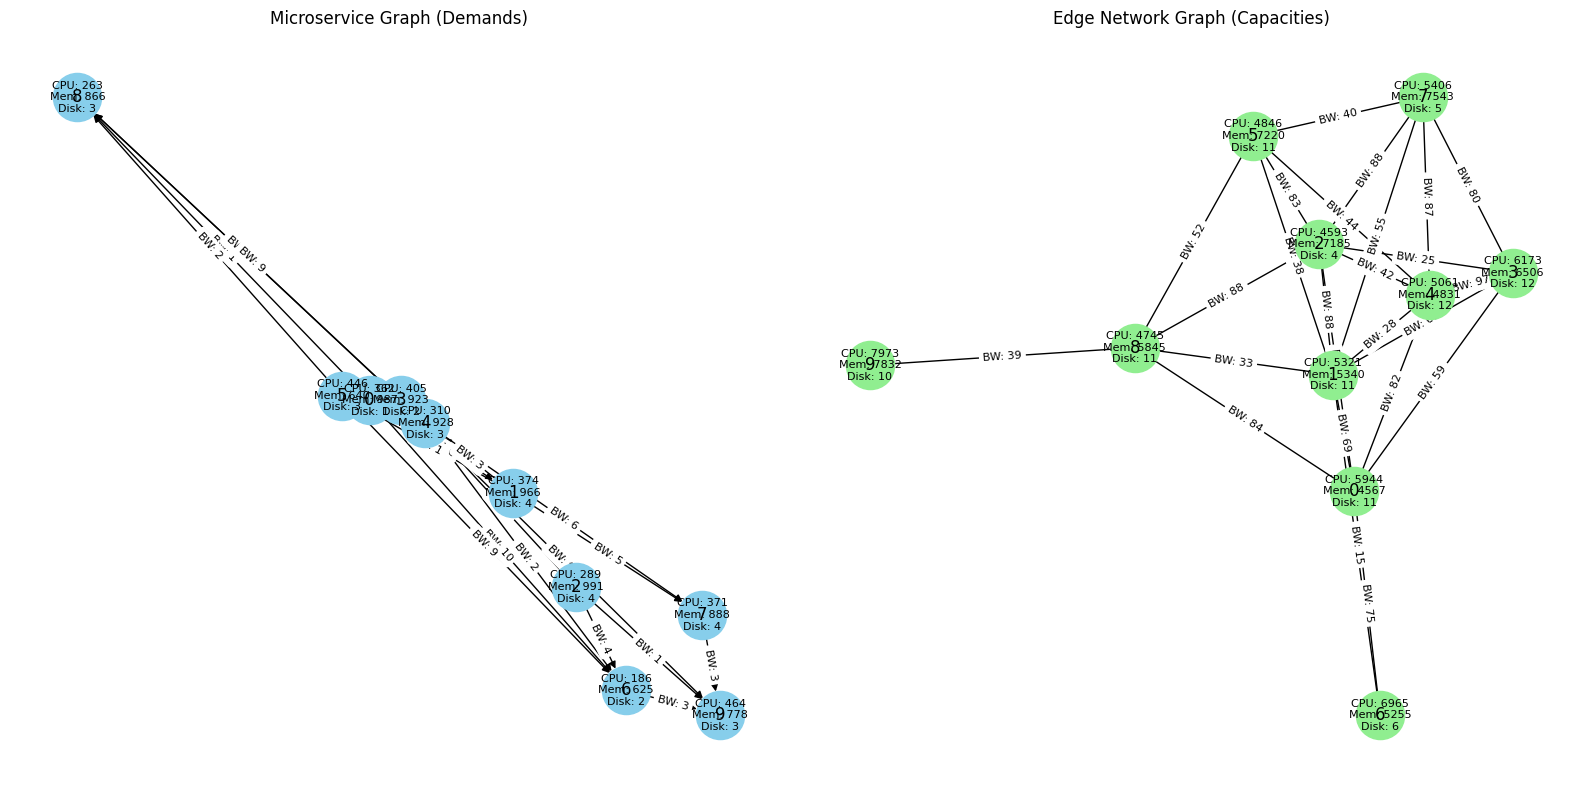

In [6]:
# Plotting Microservice Graph
plt.figure(figsize=(16, 8))

# Microservice Graph
plt.subplot(1, 2, 1)
pos_ms = nx.spring_layout(microservice_graph)
nx.draw(microservice_graph, pos_ms, with_labels=True, node_color='skyblue', node_size=1200)
labels_ms = {node: f"CPU: {microservice_graph.nodes[node]['requested_cpu']}\nMem: {microservice_graph.nodes[node]['requested_memory']}\nDisk: {microservice_graph.nodes[node]['requested_disk']}" for node in microservice_graph.nodes}
nx.draw_networkx_labels(microservice_graph, pos_ms, labels=labels_ms, font_size=8)

edge_labels_ms = {(u, v): f"BW: {data['bw_min']}" for u, v, data in microservice_graph.edges(data=True)}
nx.draw_networkx_edge_labels(microservice_graph, pos_ms, edge_labels=edge_labels_ms, font_size=8)
plt.title("Microservice Graph (Demands)")

# Edge Network Graph
plt.subplot(1, 2, 2)
pos_edge = nx.spring_layout(edge_network)
nx.draw(edge_network, pos_edge, with_labels=True, node_color='lightgreen', node_size=1200)
labels_edge = {node: f"CPU: {edge_network.nodes[node]['available_cpu']}\nMem: {edge_network.nodes[node]['available_memory']}\nDisk: {edge_network.nodes[node]['available_disk']}" for node in edge_network.nodes}
nx.draw_networkx_labels(edge_network, pos_edge, labels=labels_edge, font_size=8)

edge_labels_edge = {(u, v): f"BW: {data['bw']}" for u, v, data in edge_network.edges(data=True)}
nx.draw_networkx_edge_labels(edge_network, pos_edge, edge_labels=edge_labels_edge, font_size=8)
plt.title("Edge Network Graph (Capacities)")

plt.tight_layout()
plt.show()


In [12]:
class EdgeNetworkOptimization:
    def __init__(self, microservice_graph, edge_network):
        self.microservice_graph = microservice_graph
        self.edge_network = edge_network

        self.num_microservices = len(self.microservice_graph.nodes)
        self.num_edge_servers = len(self.edge_network.nodes)

    def get_num_microservices(self):
        return self.num_microservices

    def get_num_edge_servers(self):
        return self.num_edge_servers
        
    def compute_placement_cost(self, x, verbose=False):
        x = x.reshape(self.num_microservices, self.num_edge_servers)
        # y = y.reshape(self.num_microservices, self.num_edge_servers)

        L_ms = 0
        L_vol = 0

        # Compute costs for microservice placement
        for m1, m2, data in self.microservice_graph.edges(data=True):
            cpu_demands_m1 = self.microservice_graph.nodes[m1]["requested_cpu"]
            cpu_demands_m2 = self.microservice_graph.nodes[m2]["requested_cpu"]
            
            for n1 in range(self.num_edge_servers):
                for n2 in range(self.num_edge_servers):
                    path_cost = 1
                    # if n1 != n2:
                    #     path_cost = nx.shortest_path_length(self.edge_network, source=n1, target=n2, weight='reverse_bw')
                    
                    # Energy cost
                    energy_cost = x[m1, n1] * x[m2, n2] * (self.edge_network.nodes[n1]["energy_per_cpu_unit"] * cpu_demands_m1 + self.edge_network.nodes[n2]["energy_per_cpu_unit"] * cpu_demands_m2)
                    # Communication cost
                    communication_cost = x[m1, n1] * x[m2, n2] * path_cost
                    L_ms += 0.5 * energy_cost + 0.5 * communication_cost

        # # Compute data placement cost
        # for m in range(self.num_microservices):
        #     for n1 in range(self.num_edge_servers):
        #         for n2 in range(self.num_edge_servers):
        #             path_cost = 0
        #             if n1 != n2:
        #                 path_cost = nx.shortest_path_length(self.edge_network, source=n1, target=n2, weight='reverse_bw')
                        
        #             L_vol += x[m, n1] * y[m, n2] * path_cost

        # Soft Penalty for constraint violations
        # for m in range(self.num_microservices):
            
        #     cpu_usage = sum(x[m, n] * self.microservice_graph.nodes[m]['requested_cpu'] for n in range(self.num_edge_servers))
        #     memory_usage = sum(x[m, n] * self.microservice_graph.nodes[m]['requested_memory'] for n in range(self.num_edge_servers))
        #     # disk_usage = sum(y[m, n] for n in range(self.num_edge_servers))
        #     ms_placed_on = int(x[m].argmax(axis=-1))
        #     # print(ms_placed_on)
        #     # Soft penalties (squared terms for constraint violations)
        #     L_ms += max(0, cpu_usage - self.edge_network.nodes[ms_placed_on]['available_cpu']**2)
        #     L_ms += max(0, memory_usage -  self.edge_network.nodes[ms_placed_on]['available_memory']**2)
            # L_ms += max(0, disk_usage - max(self.edge_network.nodes[n]['available_disk'] for n in range(self.num_edge_servers)))**2

            # Disk demand constraint (soft)
            # L_ms += max(0, np.sum(y[m, :]) - self.microservice_graph.nodes[m]['requested_disk'])**2

        return L_ms + L_vol

In [13]:
# Initialize your optimization problem
optimizer = EdgeNetworkOptimization(microservice_graph, edge_network)

In [14]:
# Initial values
x0 = np.random.uniform(0, 1, size=(num_microservices * num_edge_servers))
# y0 = np.random.uniform(0, 10, size=(num_microservices * num_edge_servers))

def objective(params):
    x = params[:num_microservices * num_edge_servers].reshape(num_microservices, num_edge_servers)
    # y = params[num_microservices * num_edge_servers:].reshape(num_microservices, num_edge_servers)
    return optimizer.compute_placement_cost(x)

grad_objective = grad(objective)

In [15]:
learning_rate = 0.1
num_epochs = 100
params = x0

for epoch in range(num_epochs):
    grads = grad_objective(params)
    params = params - learning_rate * grads
    current_loss = objective(params)
    print(f"Epoch {epoch}/{num_epochs}, Loss: {current_loss}")

Epoch 0/100, Loss: 44450873344.0
Epoch 1/100, Loss: 2.7231043991896064e+16
Epoch 2/100, Loss: 1.6715352085465567e+22
Epoch 3/100, Loss: 1.026236349858334e+28
Epoch 4/100, Loss: 6.300119496171e+33
Epoch 5/100, Loss: inf


KeyboardInterrupt: 

In [ ]:
# Optimizer using JAX's minimize
result = minimize(objective, x0, method='L-BFGS-B', jac=grad_objective, options={'maxiter': 100})

In [ ]:
# Extract the results
x_opt = result.x[:num_microservices * num_edge_servers].reshape(num_microservices, num_edge_servers)
y_opt = result.x[num_microservices * num_edge_servers:].reshape(num_microservices, num_edge_servers)

print("Optimized placement (x):", x_opt)
print("Optimized disk placement (y):", y_opt)

In [42]:
def find_k_hop_neighbors(graph, node, k):
    """
    Find the k-hop neighbors of a given node in the graph.

    :param graph: A NetworkX graph
    :param node: Node for which to find neighbors
    :param k: Number of hops
    :return: A list of k-hop neighbors sorted by path cost
    """
    # Find k-hop neighbors
    neighbors = set(
        n for n, dist in nx.single_source_shortest_path_length(graph, node).items() if dist == k
    )

    # Calculate path costs for each neighbor
    neighbor_cost_pairs = []
    for neighbor in neighbors:
        path_cost = nx.shortest_path_length(graph, source=node, target=neighbor, weight='reverse_bw')
        neighbor_cost_pairs.append((neighbor, path_cost))

    # Sort neighbors by path cost
    sorted_neighbors = sorted(neighbor_cost_pairs, key=lambda x: x[1])

    # Extract and return only the sorted neighbors (without costs)
    return [neighbor for neighbor, cost in sorted_neighbors]

In [47]:
find_k_hop_neighbors(edge_network, 8, 2)

[6, 4, 3, 7]

In [ ]:
x = np.array([[0.1, ]])